In [62]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import imageio
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.ndimage import binary_erosion
import pandas as pd
import sys
import skimage
sys.path.append("../../")
from VoltageIntensityClass import VoltageIntensity
%matplotlib inline
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from alienlab.regression_func import residuals, exp_decay, regression_affine, regression_linear, get_affine_func, get_polyfit_func


In [63]:
folder_RED = glob.glob("./*autofocus_old_RED")[0]
print(folder_RED)

folder_BLUE = glob.glob("./*autofocus_old_BLUE")[0]
print(folder_BLUE)

folder_DRONPA = glob.glob("./*_calib_old_video*")[0]
print(folder_DRONPA)

.\2022-05-11_19_05_autofocus_old_RED
.\2022-05-11_19_02_autofocus_old_BLUE
.\2022-05-11_13_10_D2_calib_old_video_DRONPA2_calib_DO1


## experimental details

Absorbance max for 15µM: 0.15  
Emission spectrum collected for 15µM solution emission: 690 nm, 8nm width
DDAO and Dronpa sample for video: double glass slide with double-sided tape


Video:  
- Dronpa excited at 480nm to recover the *dispersion of intensity of blue LED spot*   
- DDAO excited at 480nm to recover the *transfert function* of the instrument and to recover the *mean fluorescence intensity from blue excitation* 10 levels of intensity.   
- DDAO excited at 650nm filter 640/20nm dichroic 665nm. From mean fluo level of blue and red excitation, and excitation spectrum: we recover the level of the blue LED. From image: we recover the dispersion of intensity.

# DDAO 15µM

[164891.969] [1288238.5]


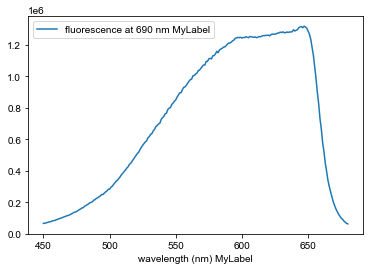

In [64]:
spectrum = pd.read_csv("2022-05-12_12_18_excitation_spectrum_690_DDAO.csv")
headers = spectrum.keys()
spectrum.plot(x = headers[1], y = headers[2])
wavelength = np.array(spectrum[headers[1]])
fluo = np.array(spectrum[headers[2]])
#plt.figure()µ
#plt.plot(wavelength, fluo)
phi_480 = fluo[wavelength == 480]
phi_640 = fluo[wavelength == 640]
print(phi_480, phi_640)

# Dronpa2 calibration

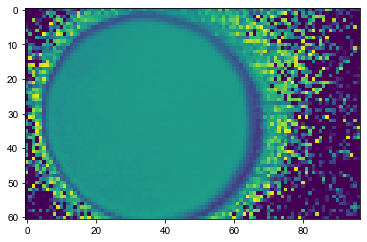

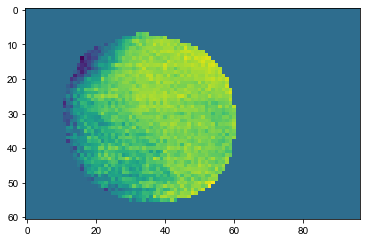

In [65]:
I_480 = np.load(glob.glob(folder_DRONPA + "/*I_480.npy")[0])
plt.imshow(I_480)
plt.figure()
np.median(I_480)
reader = imageio.get_reader(glob.glob(folder_DRONPA + "/video.tiff")[0])
im_read =  reader.get_data(10)
mask_full =im_read>4
mask = downscale_local_mean(mask_full, (10, 10))
mask = mask>0.5
mask = binary_erosion(mask, iterations= 5)
v = I_480*mask
v[v==0]=8000
plt.imshow(v)

## BLUE

In [66]:
images = glob.glob(folder_BLUE + "/images.npy")[0]
images = np.load(images)
voltages = glob.glob(folder_BLUE + "/voltage.npy")[0]
voltages = np.load(voltages)

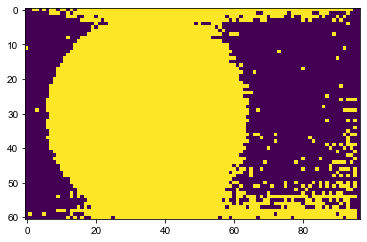

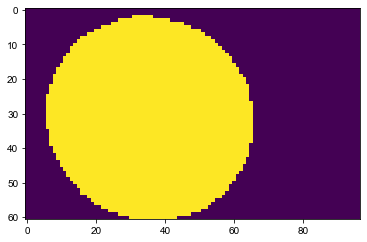

In [67]:
plt.imshow(im>0.7)
plt.figure()
plt.imshow(im_ref>4)

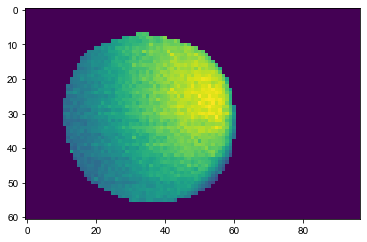

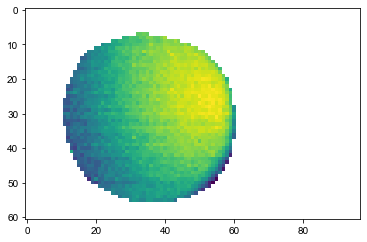

In [68]:
def max_dist(I):
    X = ndi.distance_transform_edt(I)
    x0, y0 = np.unravel_index(X.argmax(), X.shape)
    d0 = np.max(X)
    return x0, y0, d0
    
    
im = images[-1]
im = downscale_local_mean(im, (10, 10))
im_ref = downscale_local_mean(im_read, (10, 10))

n=20
im2 = np.copy(im)
im2[im2>n] = n

#shift, error, diffphase = skimage.registration.phase_cross_correlation(im_ref, im, upsample_factor=100)

x0, y0, d0 = max_dist(im>0.7) #1
x1, y1, d1 = max_dist(im_ref>4)

shift = [y1 - y0, x1 - x0]
tform = skimage.transform.AffineTransform(translation = shift)

I_480_t = skimage.transform.warp(I_480, tform)
transfert = im / I_480_t

mask_t = skimage.transform.warp(mask, tform)
plt.imshow(transfert*mask_t)
plt.figure()
plt.imshow(np.log(transfert*mask_t))



In [69]:
mean_480 = []

for i in range(10):
    im = downscale_local_mean(images[i], (10, 10))
    v = im/transfert*mask
    v[v==0]=np.quantile(v, 0.75)
    mean_480.append(np.mean(im[mask]))
    if False:
        plt.figure()
        plt.imshow(v)

mean_480 =np.array(mean_480)

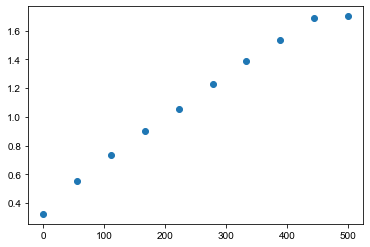

In [70]:
plt.scatter(voltages, mean_480)

# RED

In [71]:
images = glob.glob(folder_RED + "/images.npy")[0]
images = np.load(images)
voltages = glob.glob(folder_RED + "/voltage.npy")[0]
voltages = np.load(voltages)

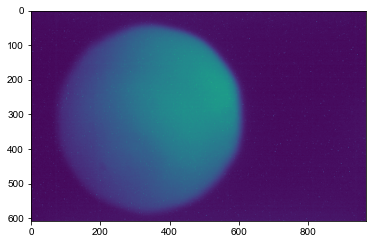

In [72]:
im = np.sum(images, axis = 0)
n=150
im[im>n] = n
plt.imshow(im)

In [73]:
mean_640 = []

for i in range(10):
    im = downscale_local_mean(images[i], (10, 10))
    v = im/transfert*mask
    v[v==0]=np.quantile(v, 0.75)
    mean_640.append(np.mean(im[mask]))
    if False:
        plt.figure()
        plt.imshow(v)
mean_640 = np.array(mean_640)

In [74]:
np.max(mean_480)

1.700355149670218

Text(0, 0.5, 'meanfluo')

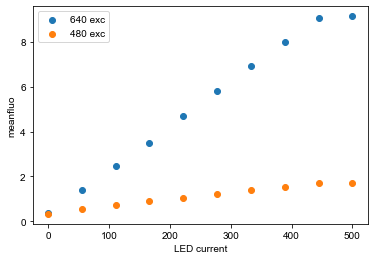

In [75]:
plt.scatter(voltages, mean_640, label = '640 exc')
plt.scatter(voltages, mean_480, label = '480 exc')
plt.legend()
plt.xlabel("LED current")
plt.ylabel("meanfluo")

In [76]:
V = VoltageIntensity(folder = "2022-05-11_16_24_bode_old_diagram_DRONPA2_CALIB")

2022-05-11_16_24_bode_old_diagram_DRONPA2_CALIB


In [77]:
dict_amplitude = {
    0: 0,
    55:1.3,
    111:2.6,
    166:3.8,
    222:5.1,
    277:6.4,
    333:7.6,
    388:8.8,
    444:10,
}

S = 0.25*d0/d1
def dict_to_func(dict_amplitude):
    x = []
    y = []
    for k in dict_amplitude.keys():
        x.append(k)
        y.append(dict_amplitude[k])
    x = np.array(x)
    y = np.array(y)
    func = get_affine_func(x, y)
    return func
    
def amp_to_eins(dict_amplitude, amplitude):
    #ref: https://fr.wikipedia.org/wiki/Einstein_(unit%C3%A9_de_mesure)
    func = dict_to_func(dict_amplitude)
    power = func(amplitude)
    eins=power*1e-3*1e3*640/120/S
    
    return eins *1.298/1.137 #using DASA1 prediction instead



-5.345819555364371
62.2959085587767
127.86664167487339
190.9355049223704
251.10067655203414
307.98938793595295
361.2579235675369
410.5916210615177
455.704871153949
496.34111770220636


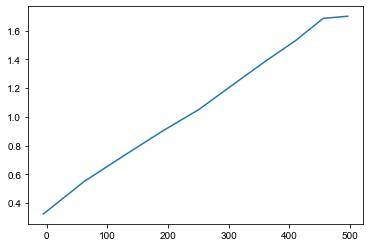

In [78]:
blues = []
for i in range(10):
    intensity_blue = V.get_intensity_voltage("blue", 1, voltages[i]/100)*1e6#*0.3
    print(intensity_blue)
    blues.append(intensity_blue)
plt.plot(blues, mean_480)
blues = np.array(blues)

intnsity predicted 275.0321807686463
intensity MPPC 245.30885511211653


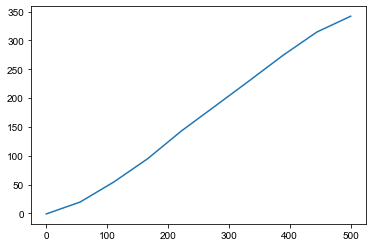

In [79]:
reds = blues * mean_640/mean_480 * phi_480/phi_640
plt.figure()
plt.plot(voltages, reds)

func = get_polyfit_func(voltages, reds, 2)

print("intnsity predicted", func(400))
print("intensity MPPC", amp_to_eins(dict_amplitude, 400))

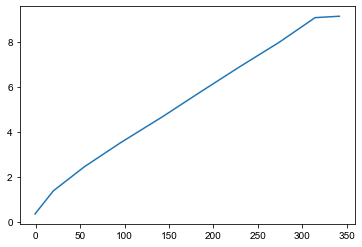

In [80]:
plt.plot(reds, mean_640)

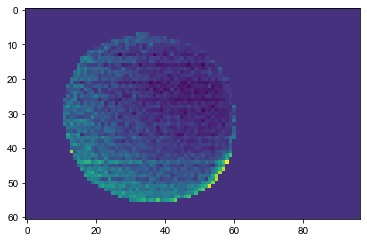

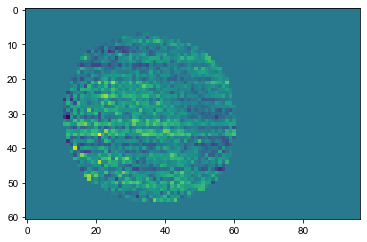

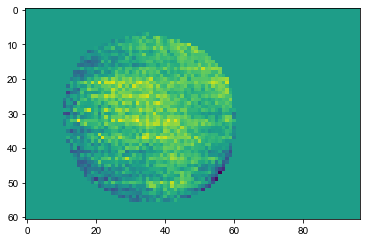

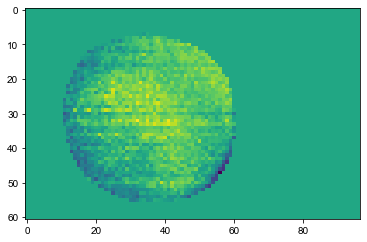

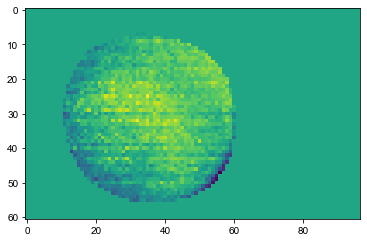

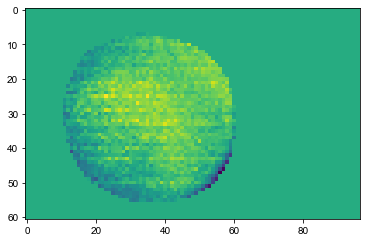

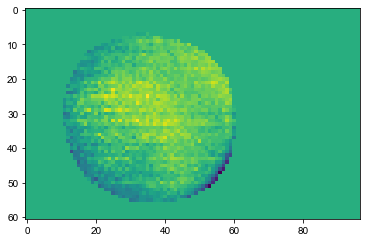

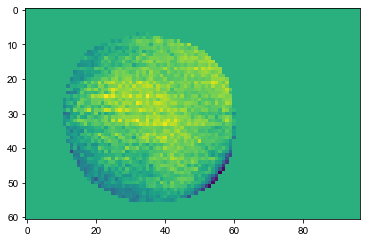

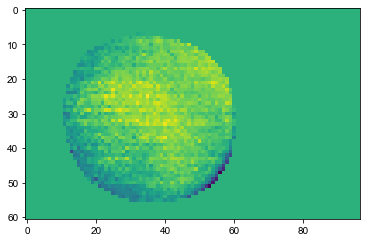

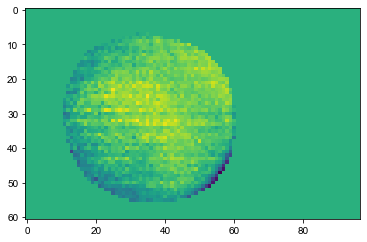

In [81]:
for image in images:
    plt.figure()
    im = downscale_local_mean(image, (10, 10))
    v = im/transfert*mask_t
    v[v==0] = np.quantile(v, 0.75)
    plt.imshow(v)